In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn import metrics

In [13]:
cr_encoded = pd.read_csv("./data/cr_encoded.csv", index_col=0)

#### To split the data in train and test data and have the same distribution of non-defaulting and defaulting rows in both I used the stratify parameter in the sklearn train_test_split function.

In [14]:
# Split Train and Test Sets
Y = cr_encoded['loan_status']
X = cr_encoded.drop('loan_status',axis=1)
 
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, stratify=Y, random_state=2020, test_size=.30)

# Baseline model

In [15]:
def model_assess(model, name='Default'):
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    preds_proba = model.predict_proba(x_test)
    print('                   ', name, '\n',
    classification_report(y_test, model.predict(x_test)))

In [16]:
    # Assess KNN
    knn = KNeighborsClassifier(n_neighbors=151)
    model_assess(knn, name='KNN')
    # Assess Logistic Regression
    lg = LogisticRegression(random_state=0)
    model_assess(lg, 'Logistic Regression')
    # Asses XGB
    xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
    model_assess(xgb, 'XGBoost')

                    KNN 
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      6899
           1       0.73      0.39      0.51      1939

    accuracy                           0.84      8838
   macro avg       0.79      0.68      0.71      8838
weighted avg       0.82      0.84      0.82      8838

                    Logistic Regression 
               precision    recall  f1-score   support

           0       0.81      0.98      0.89      6899
           1       0.73      0.17      0.27      1939

    accuracy                           0.80      8838
   macro avg       0.77      0.57      0.58      8838
weighted avg       0.79      0.80      0.75      8838

[19:20:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd l

As I saw in the eda I am dealing with imbalanced data. This is why the evaluation metrics that I am focusing on to assess the classification performance of the models are Precision, Recall and F1 score. 

Precision gives the ratio of true positives to the total positives predicted by a classifier where positives denote default cases in this context. Given that they’re the minority class in the dataset, I can see that the models do a good job at correctly predicting those minor instances.

Recall, or true positive rate, gives the number of true positives divided by the total number of elements that actually belong to the positive class. In this case, Recall is a more important metric as opposed to Precision given that I am more concerned about false negatives, meaning the model predicting that someone is not gonna default but they do, than false positives, meaning the model predicting that someone is gonna default but they don’t.

The F1 Score provides a single score to measure both Precision and Recall.
 

Miss-classifing a loan as "non-default" causes the bank to loose the most money as you can see in the image below. 

![Table](./images/default_non-default_table.png "Table")

The Recall and F1 Score for the defaults show that the xgboost gives the best results as a baseline model.

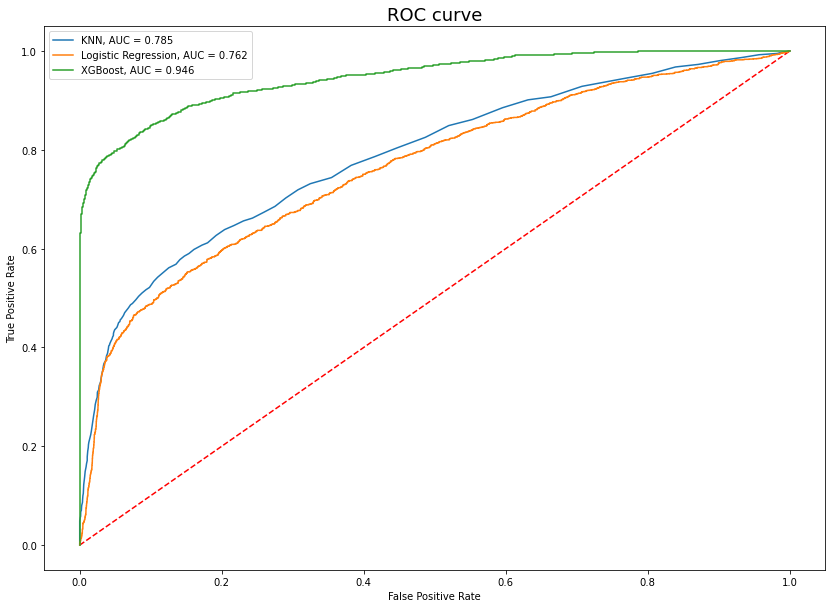

In [18]:
#ROC AUC
fig = plt.figure(figsize=(14,10))
plt.plot([0, 1], [0, 1],'r--')
#KNN
preds_proba_knn = knn.predict_proba(x_test)
probsknn = preds_proba_knn[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsknn)
aucknn = metrics.roc_auc_score(y_test, probsknn)
plt.plot(fpr, tpr, label=f'KNN, AUC = {str(round(aucknn,3))}')
#Logistic Regression
preds_proba_lg = lg.predict_proba(x_test)
probslg = preds_proba_lg[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probslg)
auclg = metrics.roc_auc_score(y_test, probslg)
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(auclg,3))}')
#XGBoost
preds_proba_xgb = xgb.predict_proba(x_test)
probsxgb = preds_proba_xgb[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsxgb)
aucxgb = metrics.roc_auc_score(y_test, probsxgb)
plt.plot(fpr, tpr, label=f'XGBoost, AUC = {str(round(aucxgb,3))}')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.show()

Also the ROC, which is a probability curve with false positive rate (FPR) on the x-axis and true postivie rate (TPR, recall) on the y-axis togther with the AUC (area under the curve) shows that the xgboost gives us the best result. 

Text(0.5, 0, 'Gain')

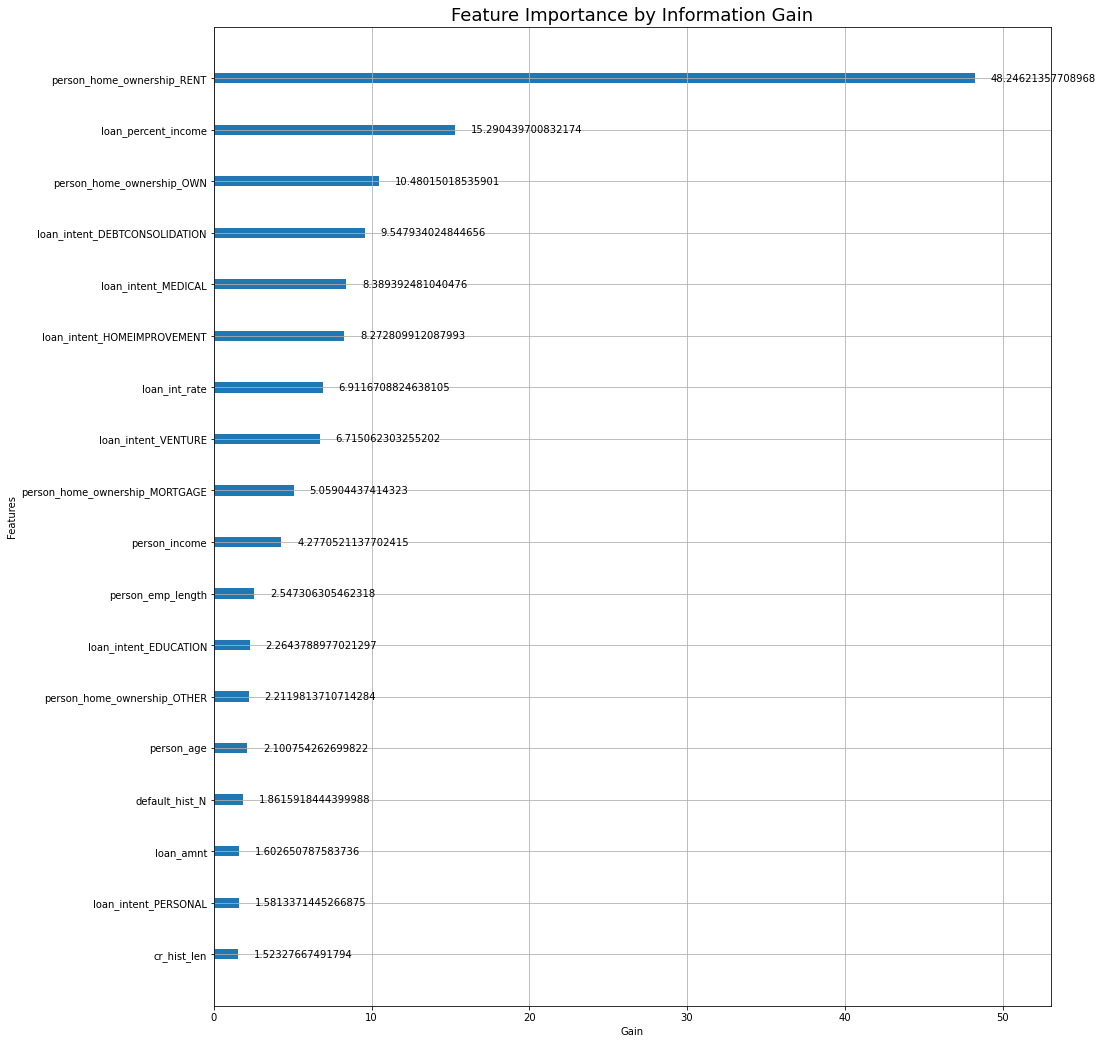

In [23]:
#Feature importance plot
fig, ax1 = plt.subplots(figsize = (15, 17), ncols=1, nrows=1)
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top = 0.9, wspace=0, hspace = 0.5)
plot_importance(xgb, importance_type='gain', ax = ax1)
ax1.set_title('Feature Importance by Information Gain', fontsize = 18)
ax1.set_xlabel('Gain')